In [1]:
import pandas as pd

merged_df = pd.read_csv("merged.csv", parse_dates=["datetime"])
merged_df.head()
merged_df.shape

(29184, 27)

In [2]:
pd.set_option('display.max_columns', None)
display(merged_df.head())

,datetime,PM10,SO2,CO,NO2,NOX,NO,O3,temp,feelslike,humidity,dew,precip,precipprob,snow,snowdepth,windgust,windspeed,winddir,pressure,visibility,cloudcover,solarradiation,solarenergy,uvindex,conditions,icon
0,2022-01-02 00:00:00,47.976,2.622,633.510,91.5125,123.564,44.600,4.0,10.0,10.0,87.38,8.0,0.0,0.0,0.0,0.0,16.6,9.4,250.0,1020.0,9.0,50.0,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night
1,2022-01-02 01:00:00,50.498,2.786,537.026,90.1475,121.566,43.642,3.6,10.0,10.0,87.38,8.0,0.0,0.0,0.0,0.0,15.5,13.0,260.0,1021.0,10.0,50.0,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night
2,2022-01-02 02:00:00,47.264,3.456,615.502,102.6875,119.832,39.820,3.4,10.0,10.0,87.38,8.0,0.0,0.0,0.0,0.0,15.8,13.0,260.0,1021.0,10.0,50.0,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night
3,2022-01-02 03:00:00,46.026,3.260,693.612,82.3575,120.728,46.062,3.7,10.0,10.0,87.38,8.0,0.0,0.0,0.0,0.0,15.5,5.4,250.0,1021.0,10.0,50.0,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night
4,2022-01-02 04:00:00,47.514,3.252,626.874,54.8325,97.116,41.600,4.0,9.0,9.0,93.45,8.0,0.0,0.0,0.0,0.0,14.4,0.0,0.0,1021.0,10.0,50.0,0.0,0.0,0.0,Partially cloudy,partly-cloudy-night


In [3]:
merged_df.isnull().sum()

datetime             0
PM10                 0
SO2                  0
CO                   0
NO2                  0
NOX                  0
NO                   0
O3                1303
temp                 0
feelslike            0
humidity             0
dew                  0
precip               0
precipprob           0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
pressure             0
visibility          56
cloudcover           0
solarradiation     297
solarenergy        297
uvindex            297
conditions           0
icon                 0
dtype: int64

In [4]:
merged_df["hour"] = merged_df["datetime"].dt.hour

o3_median = merged_df["O3"].median()

merged_df["O3"] = merged_df.apply(
    lambda row: 0 if pd.isna(row["O3"]) and (row["hour"] < 6 or row["hour"] > 19)
    else (o3_median if pd.isna(row["O3"]) else row["O3"]),
    axis=1
)


In [5]:
merged_df["visibility"] = merged_df["visibility"].fillna(merged_df["visibility"].median())

# Güneşle ilgili değişkenlerde gece saatleri için sıfır
solar_cols = ["solarradiation", "solarenergy", "uvindex"]

for col in solar_cols:
    merged_df[col] = merged_df.apply(
        lambda row: 0 if pd.isna(row[col]) and (row["hour"] < 6 or row["hour"] > 19)
        else (merged_df[col].median() if pd.isna(row[col]) else row[col]),
        axis=1
    )


In [6]:
numeric_cols = merged_df.select_dtypes(include='number').columns

negatif_kontrol = (merged_df[numeric_cols] < 0).sum()
print(negatif_kontrol[negatif_kontrol > 0])


NOX             1
O3            284
temp          171
feelslike    1159
dew          1407
dtype: int64


In [7]:
kirleticiler = ["CO", "NO2", "NOX", "NO", "O3"]

for col in kirleticiler:
    merged_df = merged_df[merged_df[col] >= 0]


In [8]:
for col in ["PM10", "SO2", "CO", "NO2", "NOX", "NO", "O3"]:
    zero_rate = (merged_df[col] == 0).mean()
    print(f"{col} → %0 oranı: {zero_rate:.2%}")

PM10 → %0 oranı: 0.00%
SO2 → %0 oranı: 0.00%
CO → %0 oranı: 0.00%
NO2 → %0 oranı: 0.00%
NOX → %0 oranı: 0.00%
NO → %0 oranı: 0.00%
O3 → %0 oranı: 3.36%


In [9]:
kirleticiler = ["PM10", "SO2", "CO", "NO2", "NOX", "NO", "O3"]

def iqr_outlier_summary(df, col, factor=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    outlier_count = ((df[col] < lower) | (df[col] > upper)).sum()
    return {
        "Q1": Q1,
        "Q3": Q3,
        "IQR": IQR,
        "Lower Bound": lower,
        "Upper Bound": upper,
        "Outlier Count": outlier_count
    }

summary = pd.DataFrame({col: iqr_outlier_summary(merged_df, col) for col in kirleticiler}).T
summary


,Q1,Q3,IQR,Lower Bound,Upper Bound,Outlier Count
PM10,29.010000,51.82800,22.818000,-5.217000,86.055000,1474.0
SO2,2.193333,3.69225,1.498917,-0.055042,5.940625,2132.0
CO,327.017000,568.41100,241.394000,-35.074000,930.502000,1986.0
NO2,32.867500,76.63000,43.762500,-32.776250,142.273750,1923.0
NOX,28.585000,75.00500,46.420000,-41.045000,144.635000,2670.0
NO,24.425000,42.72500,18.300000,-3.025000,70.175000,1767.0
O3,11.900000,52.00000,40.100000,-48.250000,112.150000,53.0


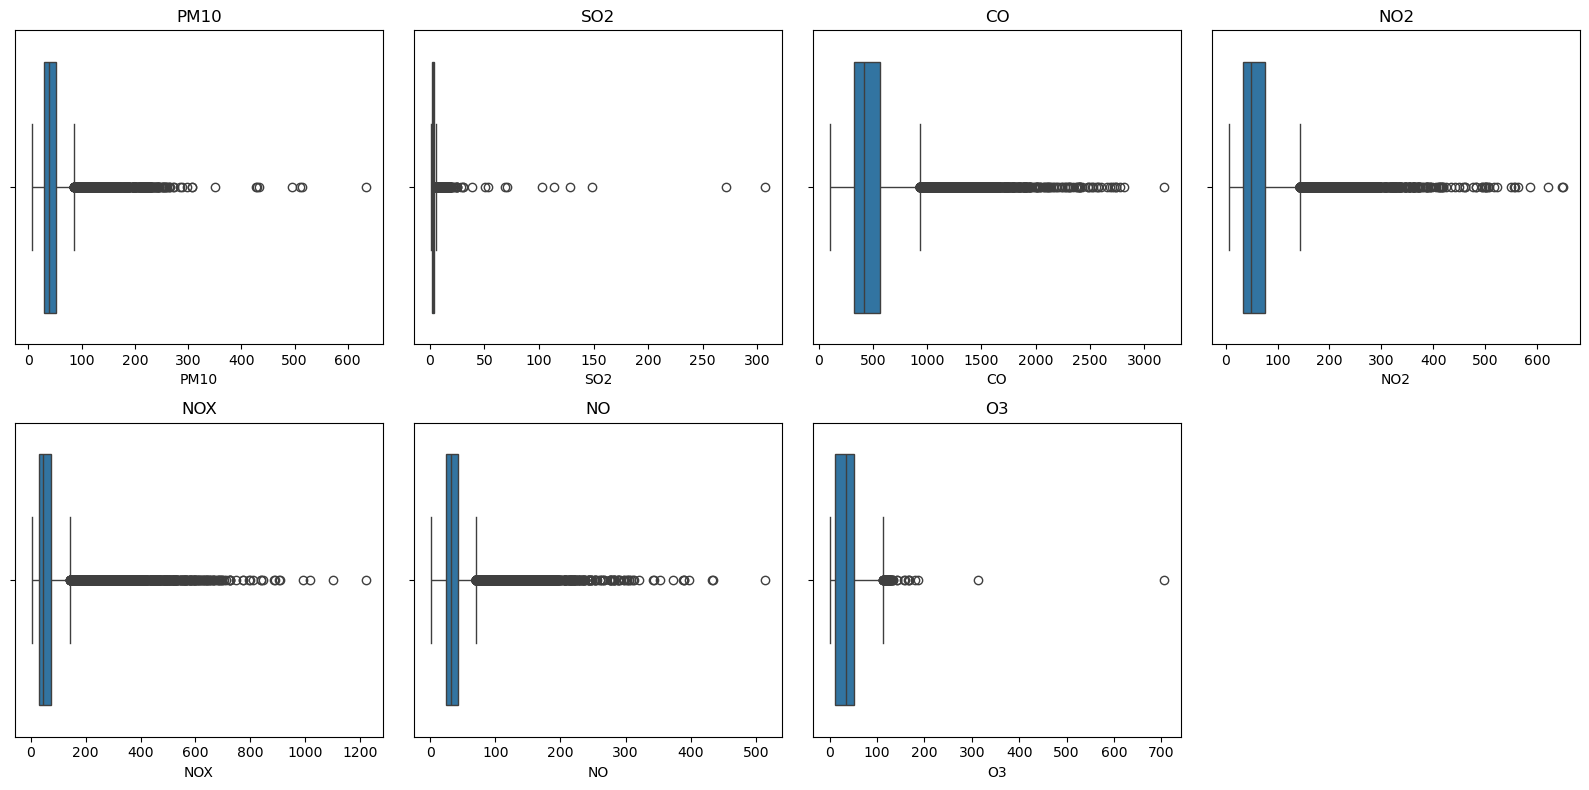

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
for i, col in enumerate(kirleticiler):
    plt.subplot(2, 4, i+1)
    sns.boxplot(x=merged_df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


In [11]:
# from sklearn.ensemble import IsolationForest

# contamination_values = {
#     "PM10": 0.04,
#     "SO2": 0.01,
#     "CO": 0.04,
#     "NO2": 0.04,
#     "NOX": 0.05,
#     "NO": 0.01,
#     "O3": 0.0005
# }

# cleaned_df = merged_df.copy()

# # Her kirletici için ayrı outlier temizliği
# for pollutant, contamination in contamination_values.items():
#     clf = IsolationForest(contamination=contamination, random_state=42)
#     preds = clf.fit_predict(cleaned_df[[pollutant]])
#     cleaned_df = cleaned_df[preds == 1]  # 1 temiz, -1 outlier

# print("Temizlik sonrası kalan veri sayısı:", len(cleaned_df))


In [12]:
from sklearn.ensemble import IsolationForest

contamination_values = {
    "PM10": 0.04,
    "SO2": 0.01,
    "CO": 0.04,
    "NO2": 0.04,
    "NOX": 0.05,
    "NO": 0.01,
    "O3": 0.0005
}

cleaned_df = merged_df.copy()

print("Isolation Forest Outlier Detection Summary:")
print("-" * 50)

for pollutant, contamination in contamination_values.items():
    clf = IsolationForest(contamination=contamination, random_state=42)
    preds = clf.fit_predict(cleaned_df[[pollutant]])
    
    total = len(preds)
    outliers = (preds == -1).sum()
    remain = (preds == 1).sum()
    
    print(f"{pollutant}: Outliers = {outliers}, Remained = {remain}, Total = {total}")
    
    # Temizleme işlemi
    cleaned_df = cleaned_df[preds == 1]


Isolation Forest Outlier Detection Summary:
--------------------------------------------------
PM10: Outliers = 1154, Remained = 27745, Total = 28899
SO2: Outliers = 277, Remained = 27468, Total = 27745
CO: Outliers = 1097, Remained = 26371, Total = 27468
NO2: Outliers = 1055, Remained = 25316, Total = 26371
NOX: Outliers = 1265, Remained = 24051, Total = 25316
NO: Outliers = 241, Remained = 23810, Total = 24051
O3: Outliers = 4, Remained = 23806, Total = 23810


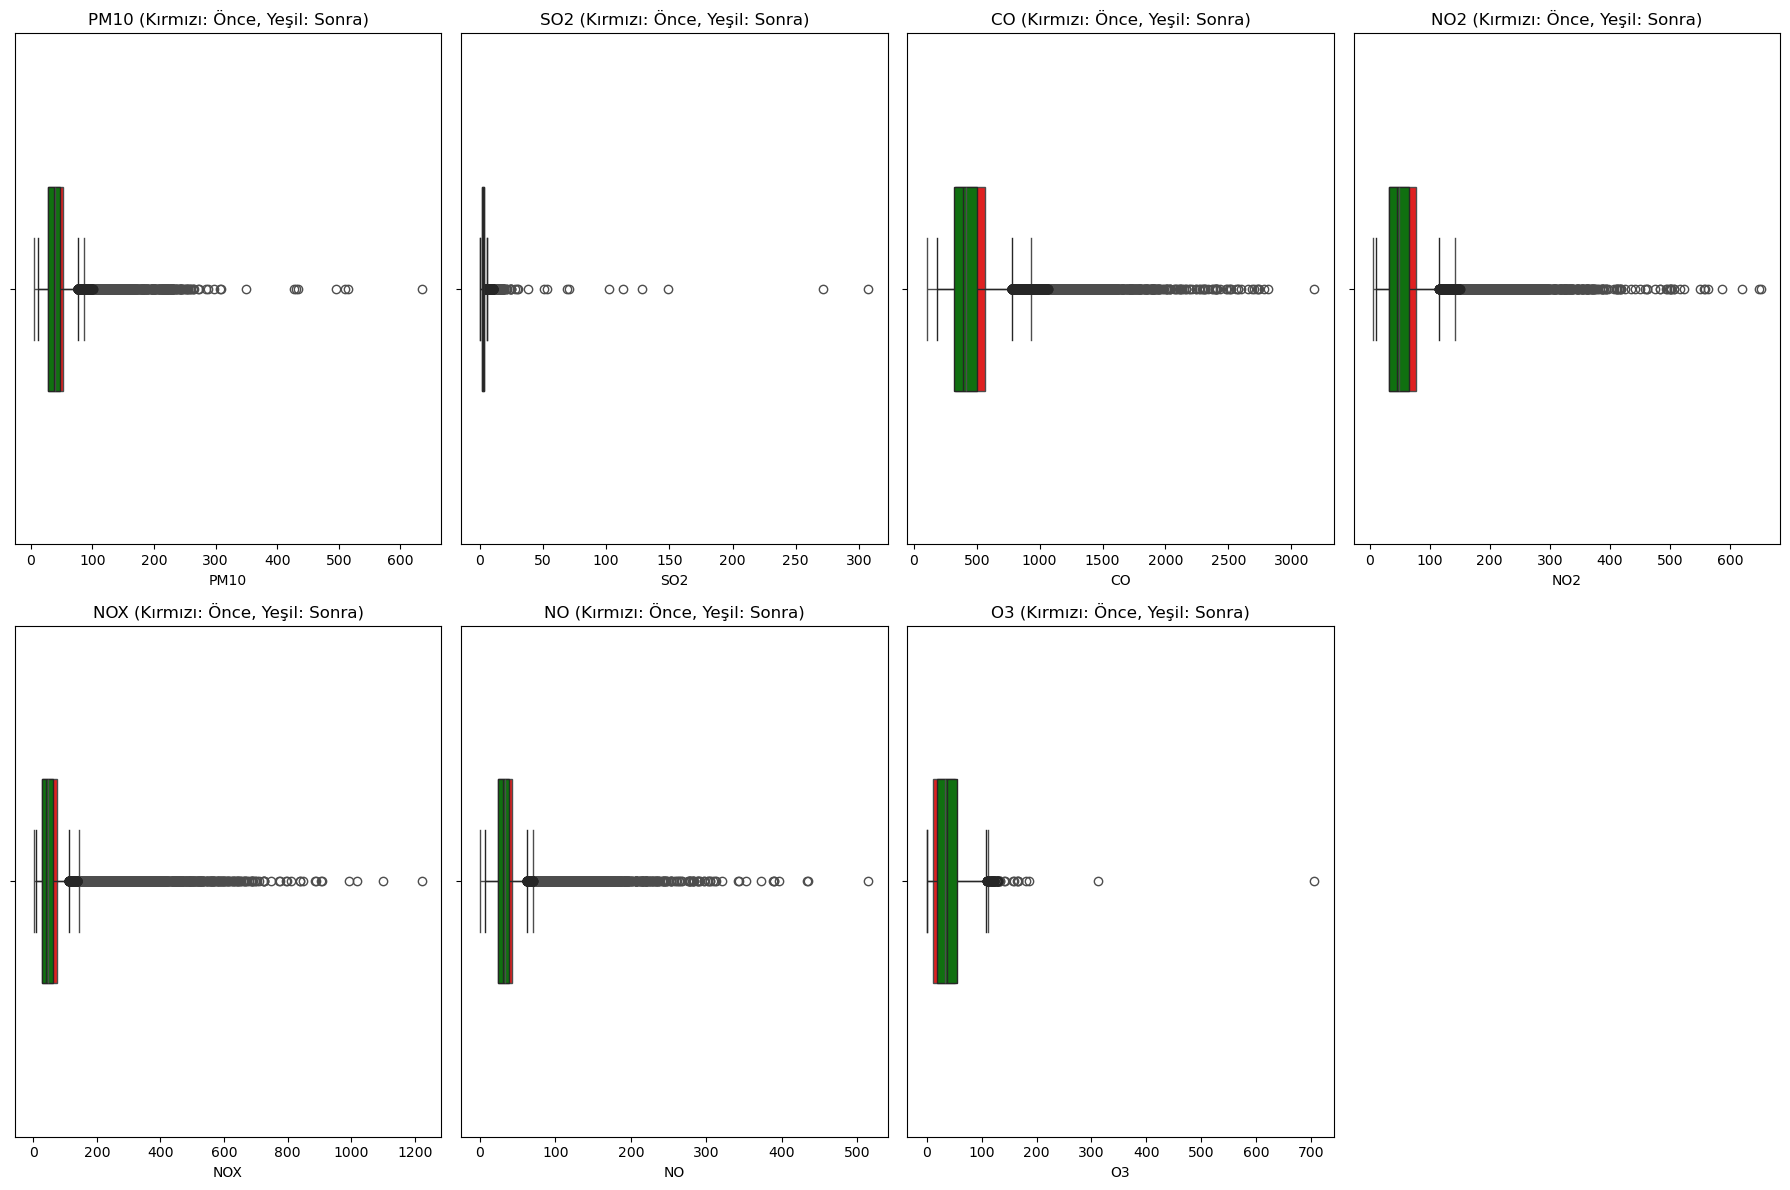

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

kirleticiler = ["PM10", "SO2", "CO", "NO2", "NOX", "NO", "O3"]

plt.figure(figsize=(18, 12))
for i, col in enumerate(kirleticiler):
    plt.subplot(2, 4, i+1)
    sns.boxplot(x=merged_df[col], color='red', width=0.4)
    sns.boxplot(x=cleaned_df[col], color='green', width=0.4)
    plt.title(f"{col} (Kırmızı: Önce, Yeşil: Sonra)")
plt.tight_layout()
plt.show()


In [14]:
def outlier_count(df, col, factor=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    return ((df[col] < lower) | (df[col] > upper)).sum()

for col in kirleticiler:
    before = outlier_count(merged_df, col)
    after = outlier_count(cleaned_df, col)
    print(f"{col}: Before = {before}, After = {after}, Removed = {before - after}")


PM10: Before = 1474, After = 477, Removed = 997
SO2: Before = 2132, After = 1661, Removed = 471
CO: Before = 1986, After = 1120, Removed = 866
NO2: Before = 1923, After = 607, Removed = 1316
NOX: Before = 2670, After = 767, Removed = 1903
NO: Before = 1767, After = 225, Removed = 1542
O3: Before = 53, After = 30, Removed = 23


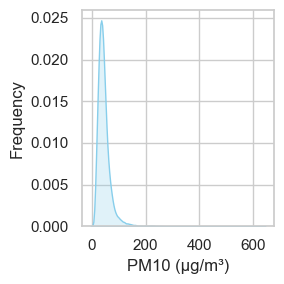

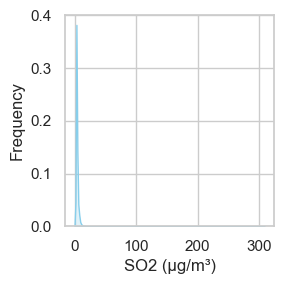

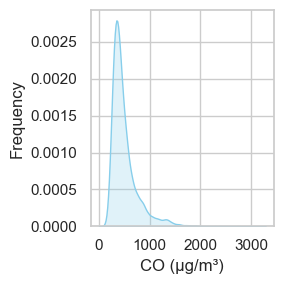

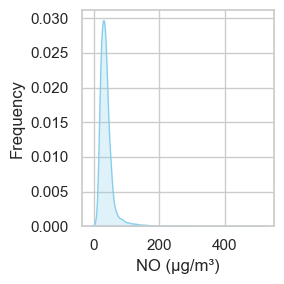

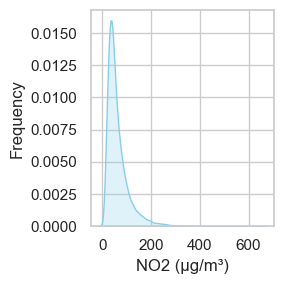

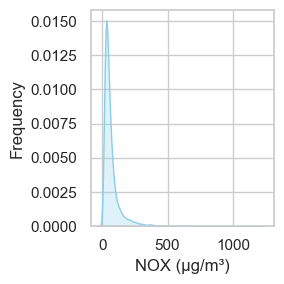

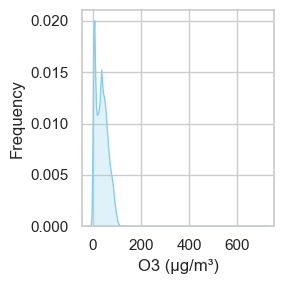

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kirletici listesi
pollutants = ['PM10', 'SO2', 'CO', 'NO', 'NO2', 'NOX', 'O3']

# Grafik stili
sns.set(style="whitegrid")

# Her kirletici için grafik çizimi
for pollutant in pollutants:
    plt.figure(figsize=(3, 3))
    sns.kdeplot(merged_df[pollutant], color='skyblue', fill = True)
    plt.xlabel(f'{pollutant} (µg/m³)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

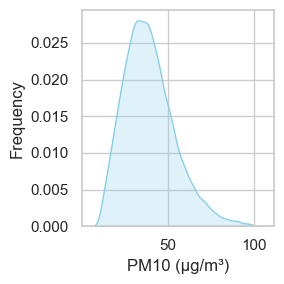

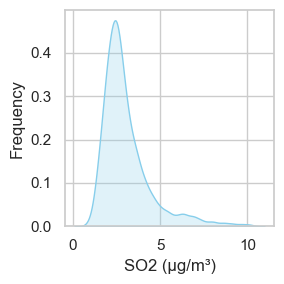

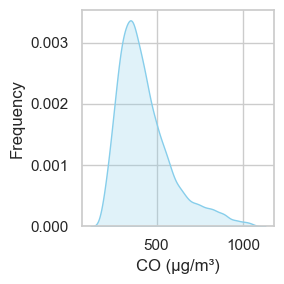

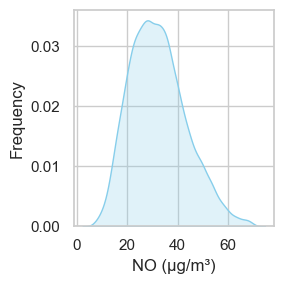

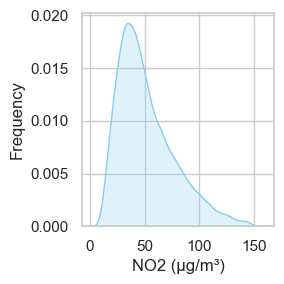

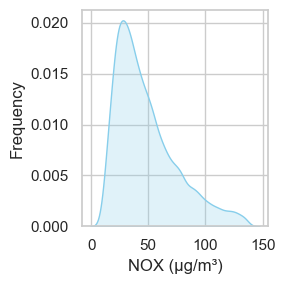

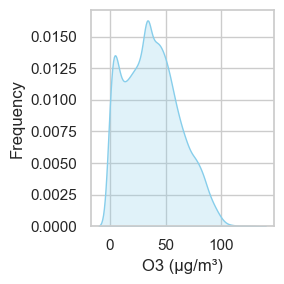

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kirletici listesi
pollutants = ['PM10', 'SO2', 'CO', 'NO', 'NO2', 'NOX', 'O3']

# Grafik stili
sns.set(style="whitegrid")

# Her kirletici için grafik çizimi
for pollutant in pollutants:
    plt.figure(figsize=(3, 3))
    sns.kdeplot(cleaned_df[pollutant], color='skyblue', fill = True)
    plt.xlabel(f'{pollutant} (µg/m³)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

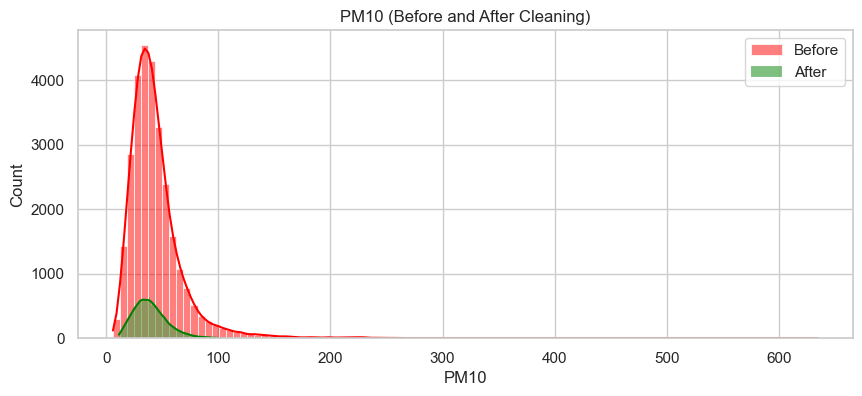

(23782, 41)
(28899, 28)


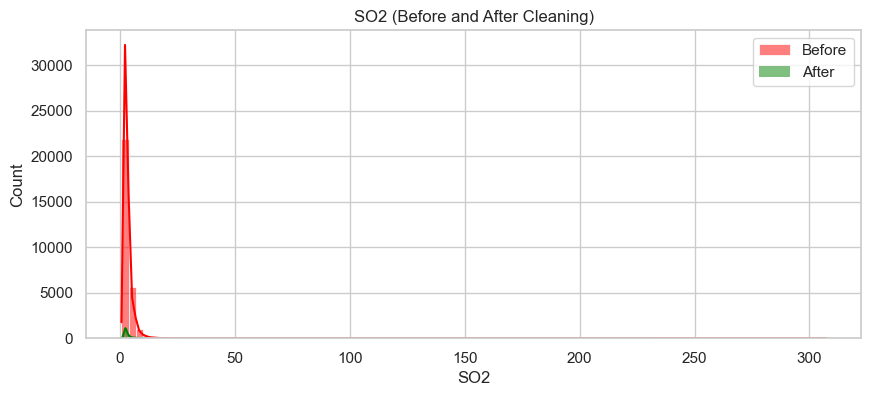

(23782, 41)
(28899, 28)


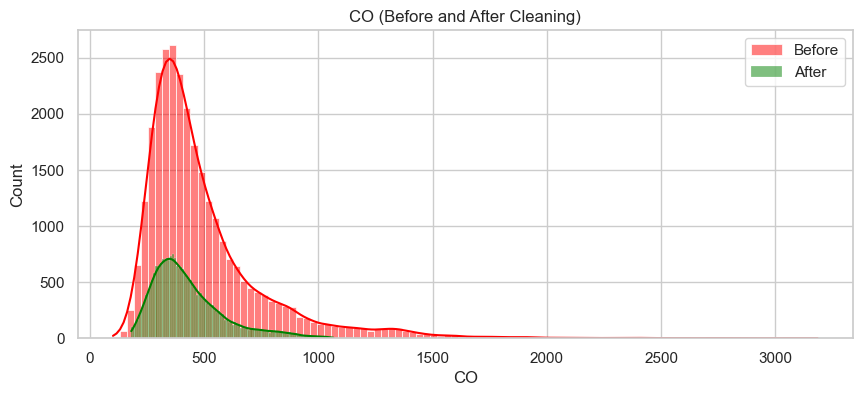

(23782, 41)
(28899, 28)


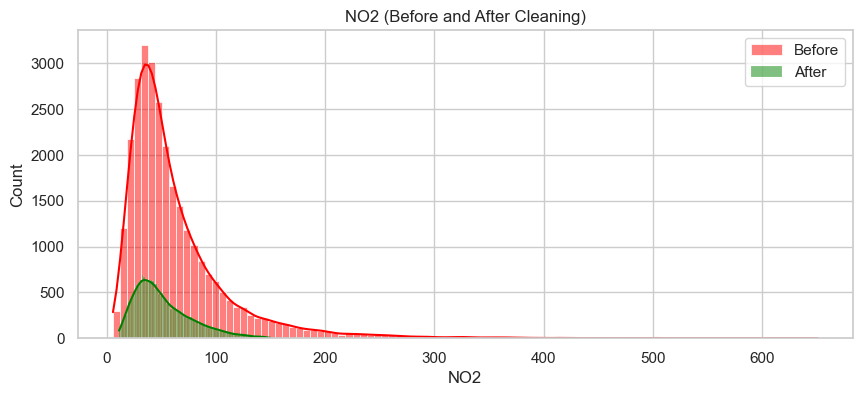

(23782, 41)
(28899, 28)


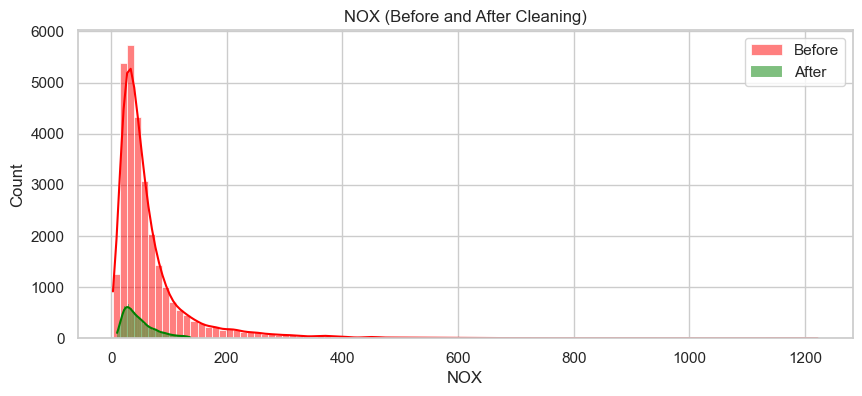

(23782, 41)
(28899, 28)


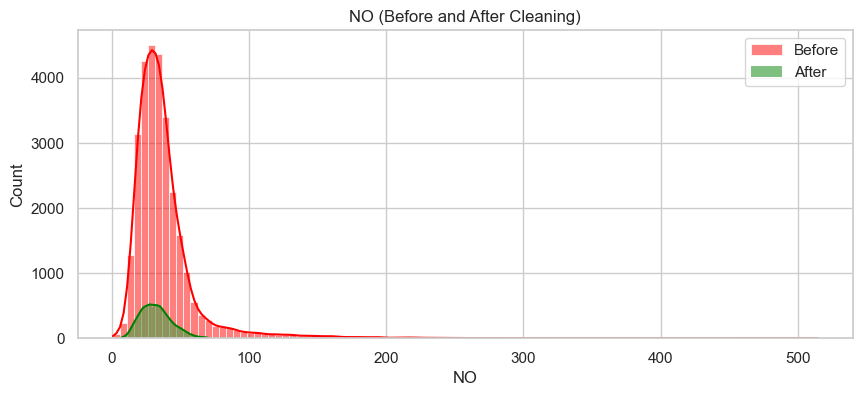

(23782, 41)
(28899, 28)


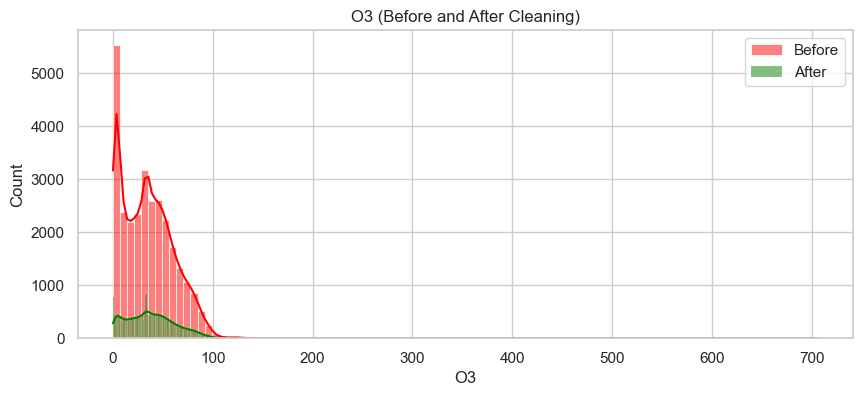

(23782, 41)
(28899, 28)


In [26]:
for col in kirleticiler:
    plt.figure(figsize=(10, 4))
    sns.histplot(merged_df[col], kde=True, color="red", label="Before", bins=100)
    sns.histplot(cleaned_df[col], kde=True, color="green", label="After", bins=100)
    plt.title(f"{col} (Before and After Cleaning)")
    plt.legend()
    plt.show()

    print(cleaned_df.shape)
    print(merged_df.shape)


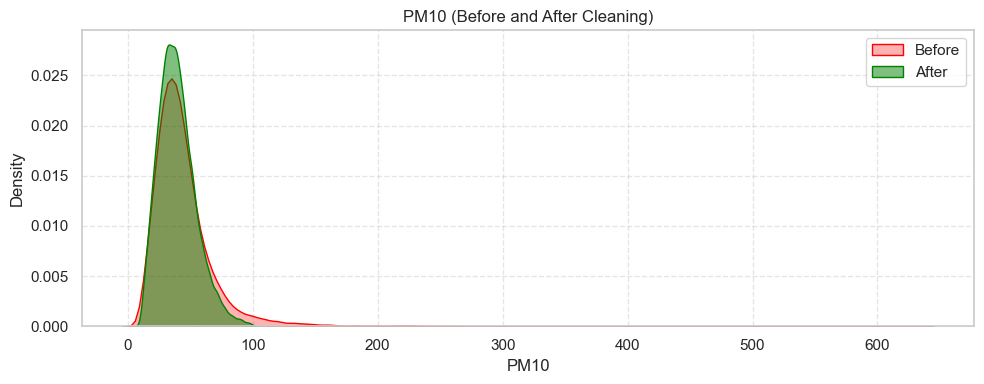

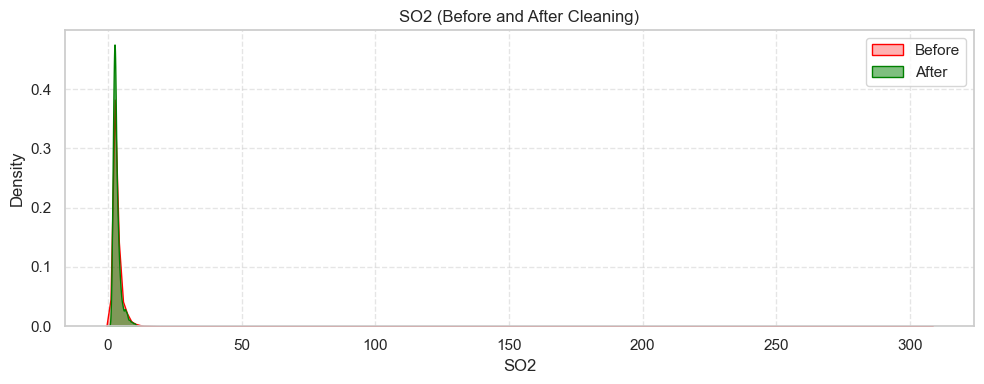

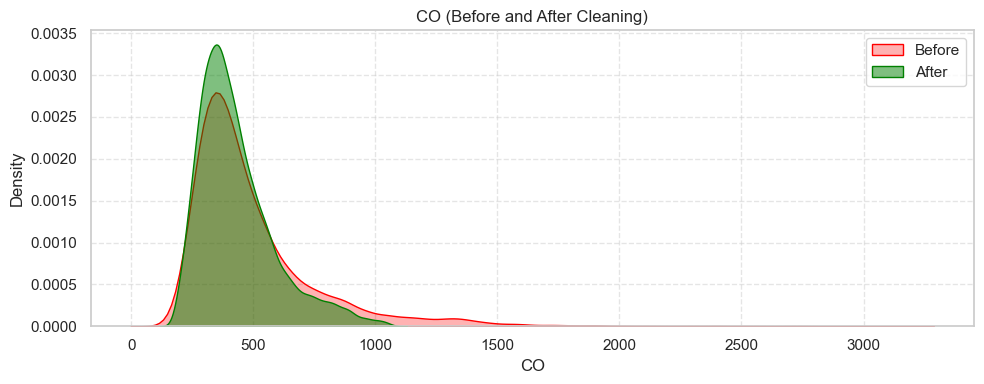

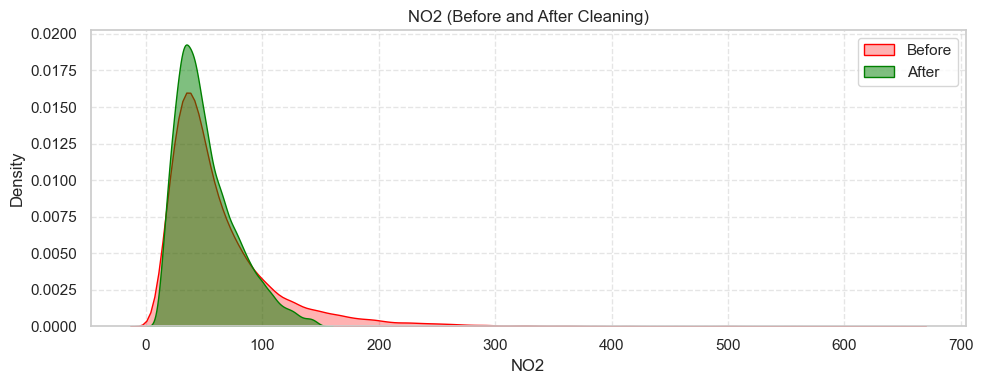

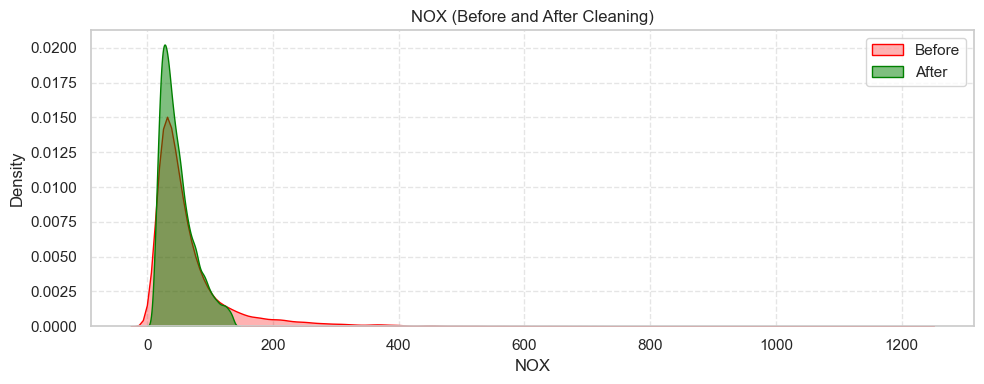

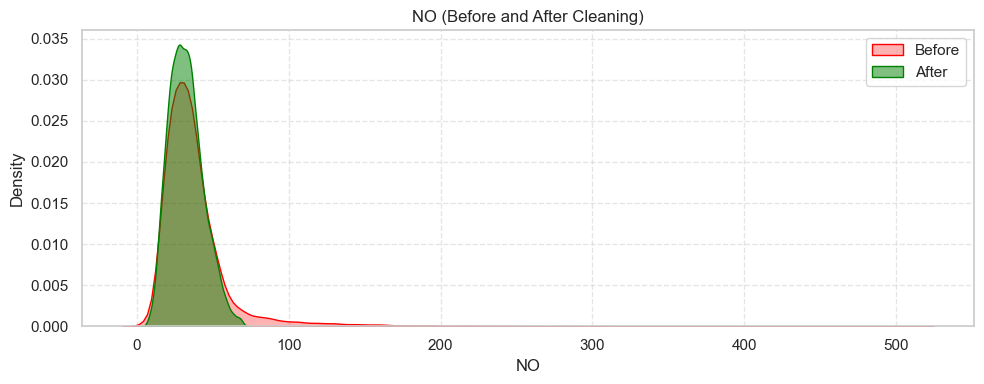

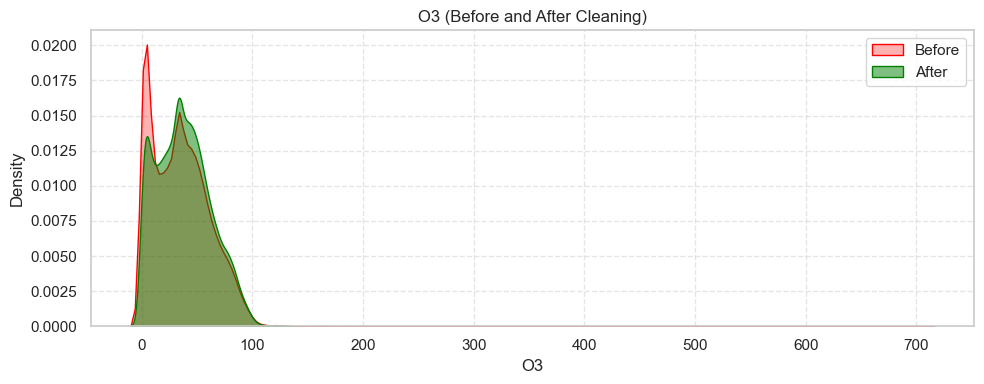

In [27]:
for col in kirleticiler:
    plt.figure(figsize=(10, 4))
    
    sns.kdeplot(merged_df[col], color="red", label="Before", fill=True, alpha=0.3)
    sns.kdeplot(cleaned_df[col], color="green", label="After", fill=True, alpha=0.5)
    
    plt.title(f"{col} (Before and After Cleaning)")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


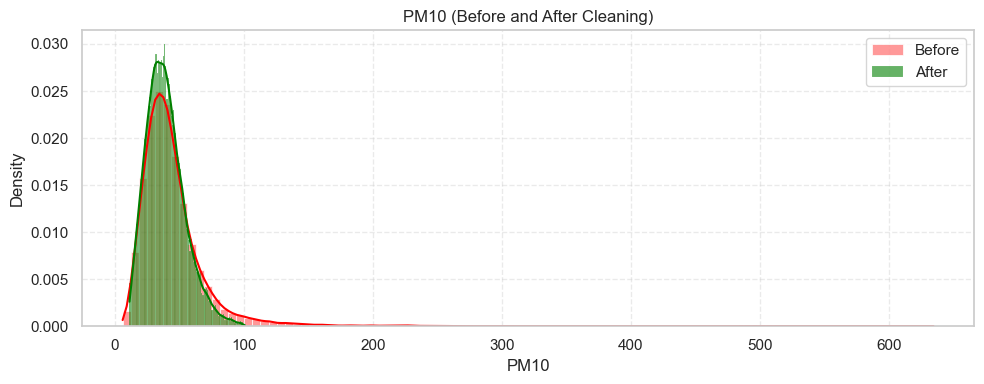

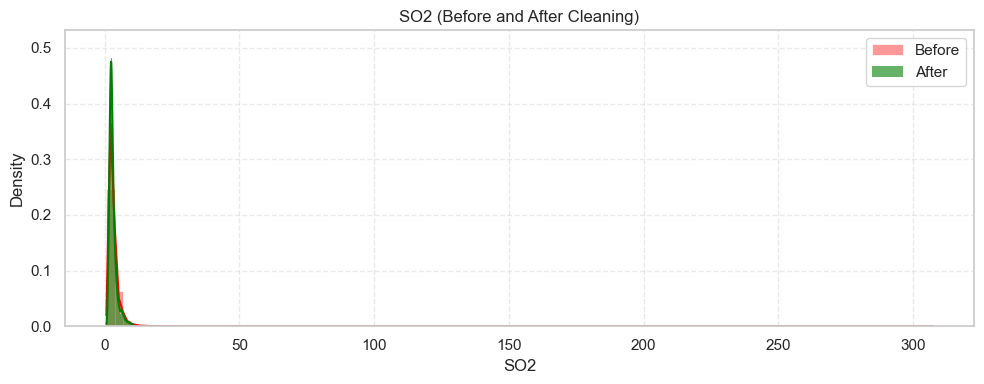

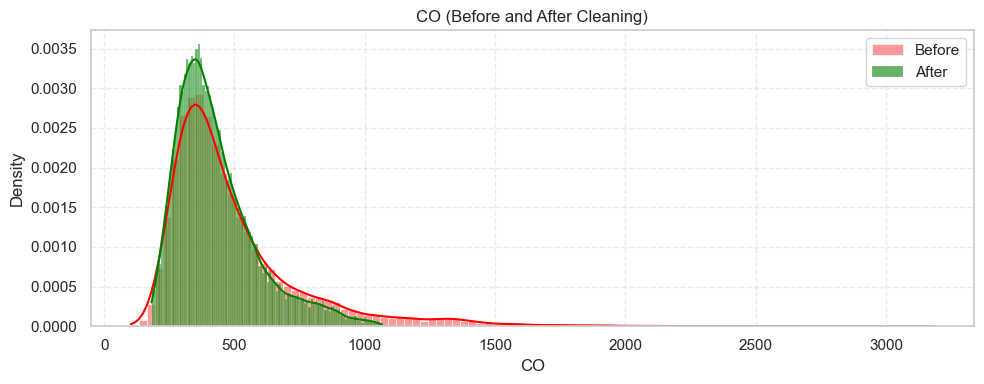

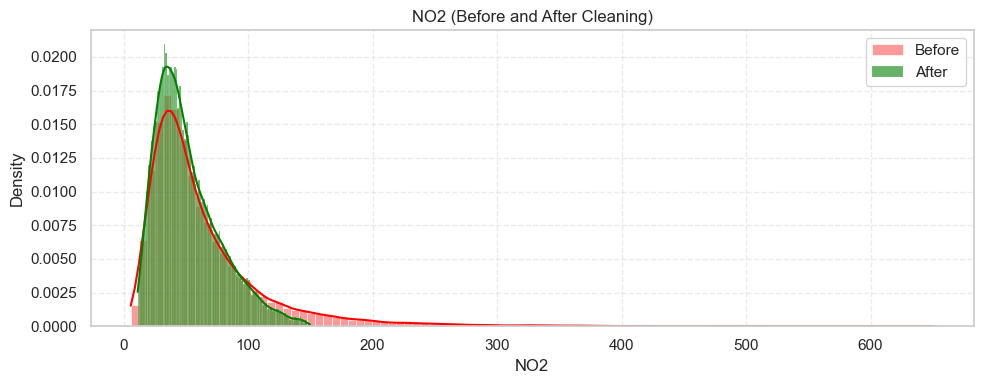

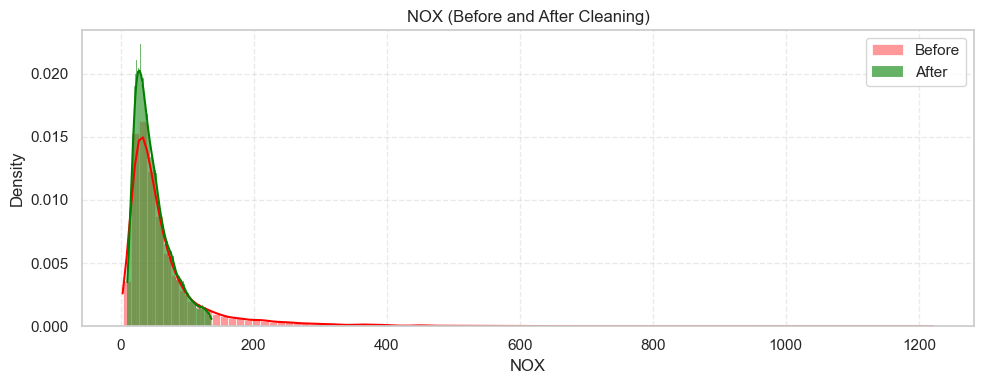

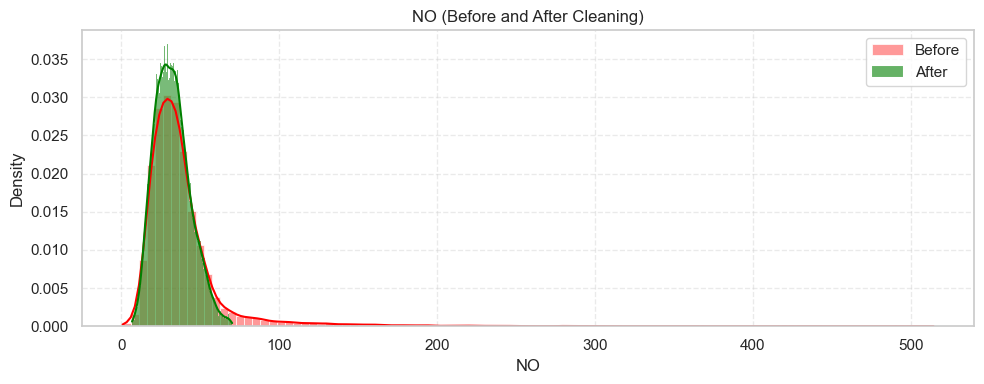

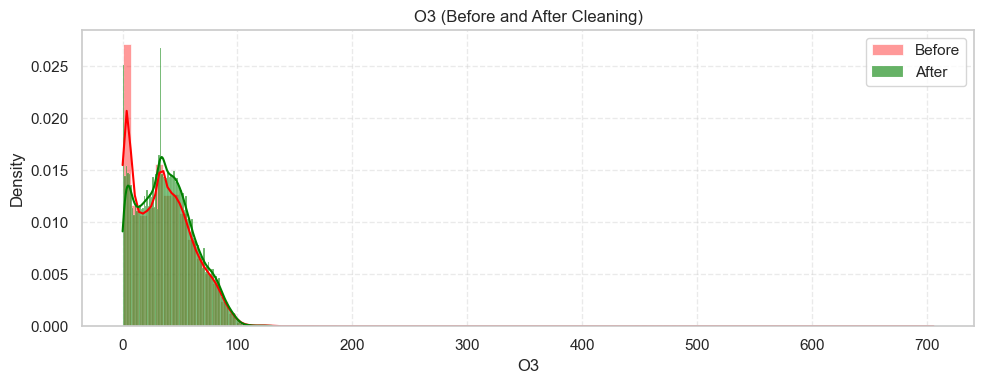

In [28]:
for col in kirleticiler:
    plt.figure(figsize=(10, 4))
    
    sns.histplot(merged_df[col], kde=True, color="red", label="Before", bins=100, stat="density", alpha=0.4)
    sns.histplot(cleaned_df[col], kde=True, color="green", label="After", bins=100, stat="density", alpha=0.6)
    
    plt.title(f"{col} (Before and After Cleaning)")
    plt.legend()
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


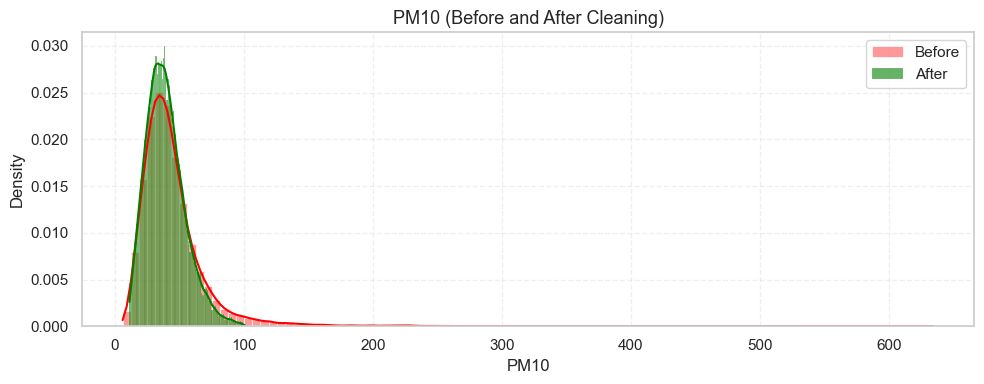

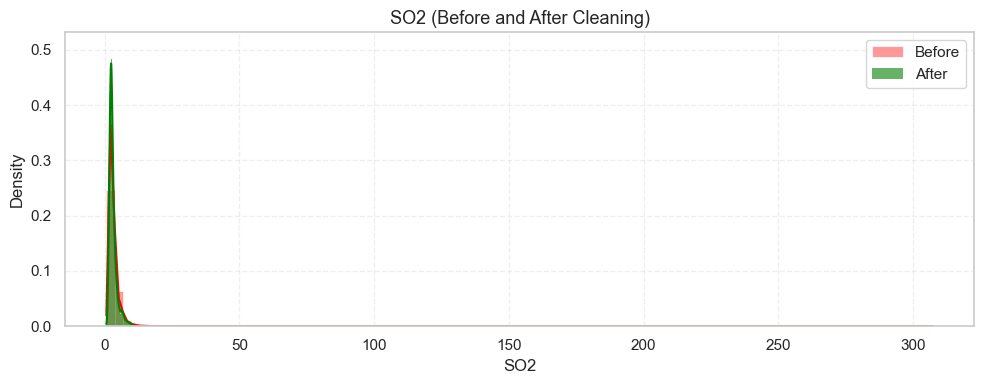

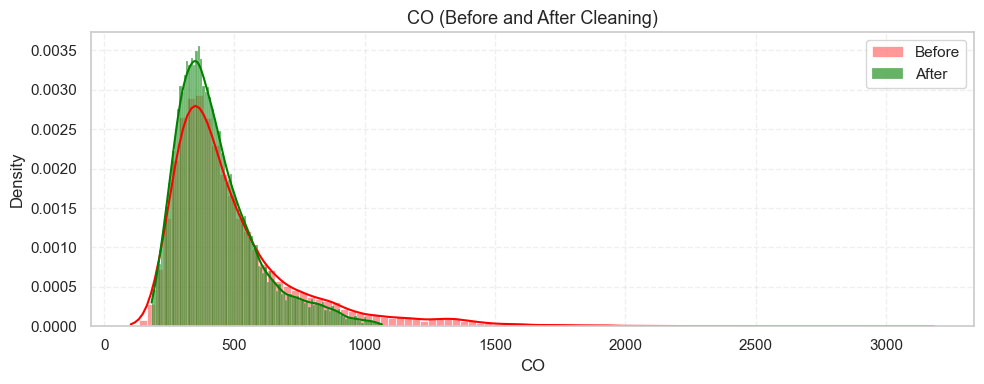

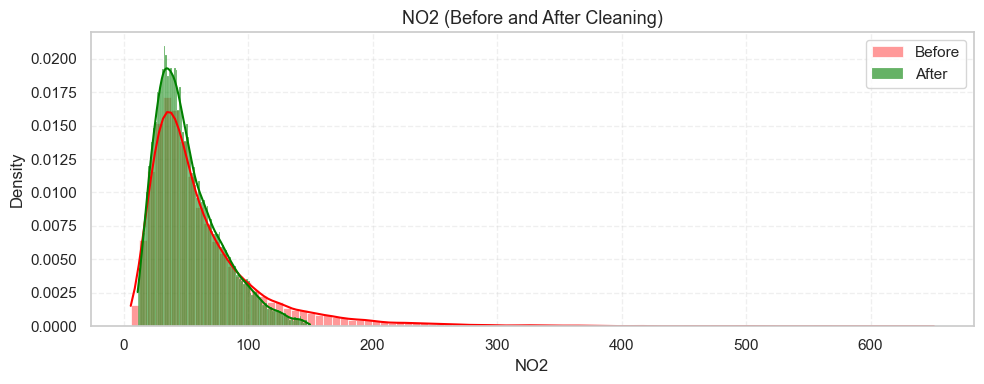

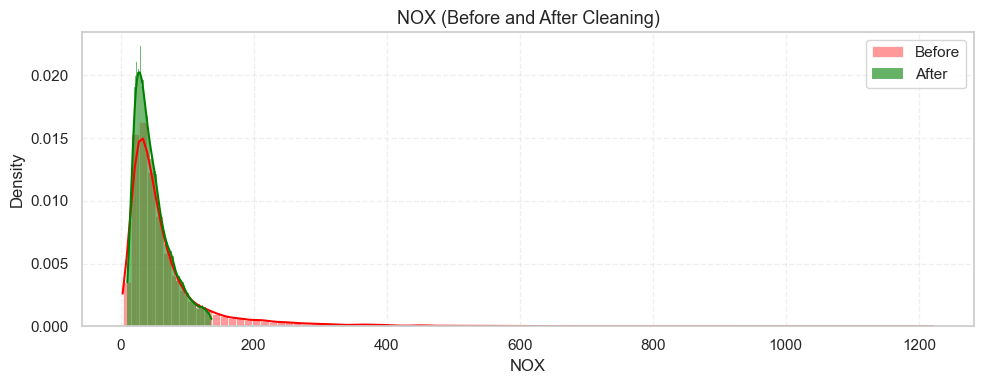

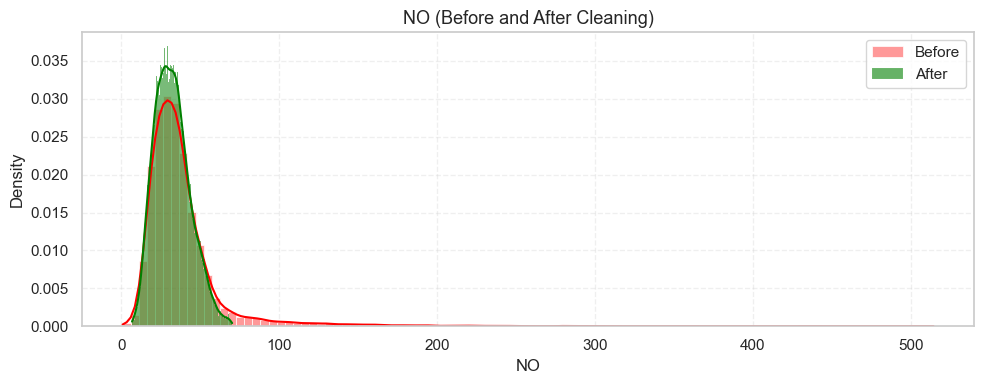

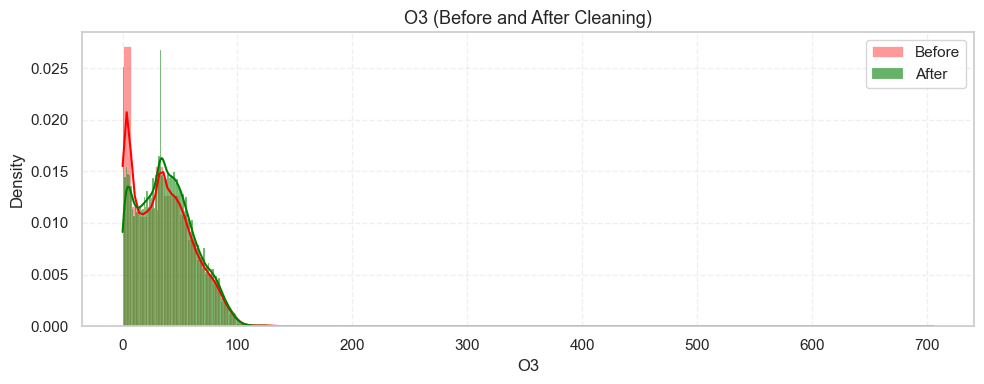

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kirleticiler listesini kendine göre tanımla
kirleticiler = ['PM10', 'SO2', 'CO', 'NO2', 'NOX', 'NO', 'O3']  # örnek

for col in kirleticiler:
    plt.figure(figsize=(10, 4))

    # Ham veri (Before)
    sns.histplot(
        merged_df[col],
        bins=100,
        kde=True,
        color="red",
        label="Before",
        stat="density",
        alpha=0.4
    )

    # Temizlenmiş veri (After)
    sns.histplot(
        cleaned_df[col],
        bins=100,
        kde=True,
        color="green",
        label="After",
        stat="density",
        alpha=0.6
    )

    plt.title(f"{col} (Before and After Cleaning)", fontsize=13)
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


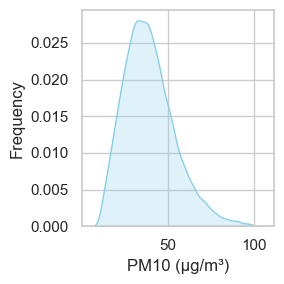

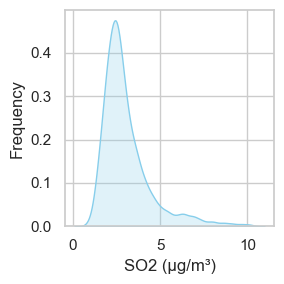

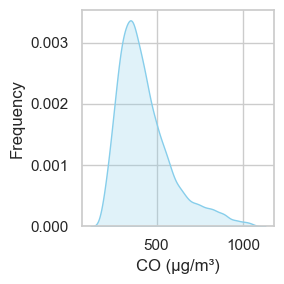

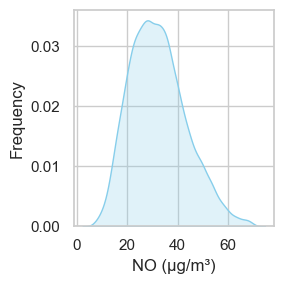

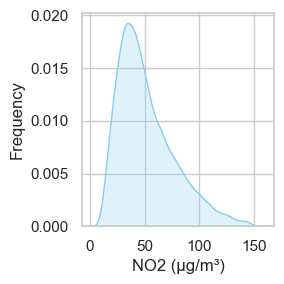

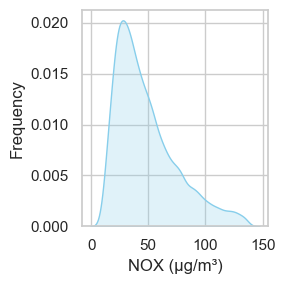

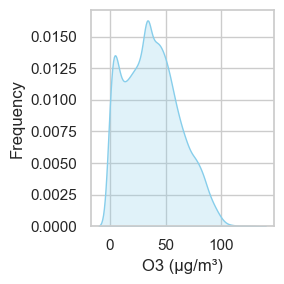

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kirletici listesi
pollutants = ['PM10', 'SO2', 'CO', 'NO', 'NO2', 'NOX', 'O3']

# Grafik stili
sns.set(style="whitegrid")

# Her kirletici için grafik çizimi
for pollutant in pollutants:
    plt.figure(figsize=(3, 3))
    sns.kdeplot(cleaned_df[pollutant], color='skyblue', fill = True)
    plt.xlabel(f'{pollutant} (µg/m³)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [18]:
#-----------------------------------------------Feature Engineering-------------------------------------------------------

In [19]:
import numpy as np
import pandas as pd

# Tarih/zaman temelli
cleaned_df["hour"] = cleaned_df["datetime"].dt.hour
cleaned_df["day"] = cleaned_df["datetime"].dt.day
cleaned_df["month"] = cleaned_df["datetime"].dt.month
cleaned_df["dayofweek"] = cleaned_df["datetime"].dt.weekday
cleaned_df["season"] = (cleaned_df["month"] % 12) // 3 + 1

# Rüzgar yönü sin/cos dönüşümü
cleaned_df["wind_dir_rad"] = np.deg2rad(cleaned_df["winddir"])
cleaned_df["wind_dir_sin"] = np.sin(cleaned_df["wind_dir_rad"])
cleaned_df["wind_dir_cos"] = np.cos(cleaned_df["wind_dir_rad"])

# Hava durumu kodlaması
def group_conditions(condition):
    if pd.isna(condition):
        return 'Other'
    condition = condition.lower()
    if 'snow' in condition:
        return 'Snowy'
    elif 'rain' in condition:
        return 'Rainy'
    elif 'overcast' in condition:
        return 'Overcast'
    elif 'clear' in condition:
        return 'Clear'
    elif 'partially' in condition or 'cloud' in condition:
        return 'Partly Cloudy'
    else:
        return 'Other'

cleaned_df['weather_group'] = cleaned_df['conditions'].apply(group_conditions)


group_code_map = {
    'Partly Cloudy': 0,
    'Clear': 1,
    'Overcast': 2,
    'Rainy': 3,
    'Snowy': 4,
    'Other': 5
}
cleaned_df["weather_group_code"] = cleaned_df["weather_group"].map(group_code_map)


cleaned_df["is_rainy"] = (cleaned_df["weather_group"] == "Rainy").astype(int)
cleaned_df["is_snowy"] = (cleaned_df["weather_group"] == "Snowy").astype(int)


cleaned_df = cleaned_df[cleaned_df["weather_group"] != "Snowy"]


def humidity_level(h):
    if h < 30:
        return 0  
    elif h < 70:
        return 1 
    else:
        return 2  

cleaned_df["humidity_level"] = cleaned_df["humidity"].apply(humidity_level)


cleaned_df["feelslike_diff"] = cleaned_df["feelslike"] - cleaned_df["temp"]


cleaned_df["is_weekend"] = cleaned_df["dayofweek"].apply(lambda x: 1 if x >= 5 else 0)
cleaned_df["is_nighttime"] = cleaned_df["hour"].apply(lambda x: 1 if (x < 6 or x >= 20) else 0)
cleaned_df["is_rush_hour"] = cleaned_df["hour"].apply(lambda x: 1 if x in [7, 8, 9 ,17, 18, 19] else 0)


cleaned_df["humid_heat_index"] = cleaned_df["humidity"] * cleaned_df["temp"]


def uv_level(u):
    if u <= 2:
        return 0  
    elif u <= 5:
        return 1  
    else:
        return 2  
cleaned_df["uv_level"] = cleaned_df["uvindex"].apply(uv_level)



In [20]:
cleaned_df.drop(columns=[
    "humid_heat_index", "uv_level","humidity_level", "feelslike_diff", "is_rainy",
], inplace=True)

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Korelasyon matrisini hesapla
corr = cleaned_df.corr()

# Grafik boyutunu ayarla
plt.figure(figsize=(18, 14))

# Isı haritasını çiz
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=.5)

# Başlık ekle
plt.title("Correlation Heatmap", fontsize=12)
plt.tight_layout()
plt.show()


ValueError: could not convert string to float: 'Partially cloudy'

In [ ]:
cleaned_df.drop(columns=["is_snowy"], inplace=True)
cleaned_df.drop(columns=[
    "precip", "precipprob", "snow", "snowdepth",
    "datetime", "conditions", "icon", "weather_group"
], inplace=True)

In [ ]:
cleaned_df.drop(columns=[
    "solarenergy", "uvindex", "winddir"
], inplace=True)

In [ ]:
pd.set_option('display.max_columns', None)
display(cleaned_df.head())
cleaned_df.shape

,PM10,SO2,CO,NO2,NOX,NO,O3,temp,feelslike,humidity,dew,windgust,windspeed,pressure,visibility,cloudcover,solarradiation,hour,day,month,dayofweek,season,wind_dir_rad,wind_dir_sin,wind_dir_cos,weather_group_code,is_weekend,is_nighttime,is_rush_hour
0,47.976,2.622,633.510,91.5125,123.564,44.600,4.0,10.0,10.0,87.38,8.0,16.6,9.4,1020.0,9.0,50.0,0.0,0,2,1,6,1,4.363323,-0.939693,-0.342020,0,1,1,0
1,50.498,2.786,537.026,90.1475,121.566,43.642,3.6,10.0,10.0,87.38,8.0,15.5,13.0,1021.0,10.0,50.0,0.0,1,2,1,6,1,4.537856,-0.984808,-0.173648,0,1,1,0
2,47.264,3.456,615.502,102.6875,119.832,39.820,3.4,10.0,10.0,87.38,8.0,15.8,13.0,1021.0,10.0,50.0,0.0,2,2,1,6,1,4.537856,-0.984808,-0.173648,0,1,1,0
3,46.026,3.260,693.612,82.3575,120.728,46.062,3.7,10.0,10.0,87.38,8.0,15.5,5.4,1021.0,10.0,50.0,0.0,3,2,1,6,1,4.363323,-0.939693,-0.342020,0,1,1,0
4,47.514,3.252,626.874,54.8325,97.116,41.600,4.0,9.0,9.0,93.45,8.0,14.4,0.0,1021.0,10.0,50.0,0.0,4,2,1,6,1,0.000000,0.000000,1.000000,0,1,1,0


(23782, 29)

In [ ]:
cleaned_df.to_csv("cleaned_final.csv", index=False)